In [0]:
import pandas as pd
import numpy as np
import os
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

%load_ext tensorboard

import matplotlib.pyplot as plt
from skimage import color, exposure

from sklearn.metrics import accuracy_score

In [2]:
cd '/content/drive/My Drive/Colab Notebooks/matrix/matrix_three/dw_matrix_road_sign'

/content/drive/My Drive/Colab Notebooks/matrix/matrix_three/dw_matrix_road_sign


In [0]:
train = pd.read_pickle('data/train.p')
test = pd.read_pickle('data/test.p')

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

sign_labels = pd.read_csv('data/signnames.csv')
labels_dict = sign_labels.to_dict()['b']

In [4]:
y_train

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

In [5]:
len(np.unique(y_train))

43

In [6]:
to_categorical(y_train)[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [0]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)

In [0]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [9]:
model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Flatten(),
    Dense(num_classes, activation='softmax')
])

#model.summary()

model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
model.fit(X_train, y_train)

1088/1088 [==============================] - 4s 4ms/step - loss: 12.7465 - accuracy: 0.7725


In [0]:
def get_cnn_v1(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Flatten(),
    Dense(num_classes, activation='softmax')
    ])
  
def train_model(model, X_train, y_train, params_fit={}):
  model.compile(loss='categorical_crossentropy',optimizer='Adam', metrics=['accuracy'])
  
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  
  model.fit(
      X_train,
      y_train,
      batch_size=params_fit.get('batch_size',128),
      epochs=params_fit.get('epochs', 5),
      verbose=params_fit.get('verbose', 1),
      validation_data=params_fit.get('validation_data', (X_train, y_train)),
      callbacks=[tensorboard_callback]      
      )
  return model

In [11]:
model = get_cnn_v1(input_shape, num_classes)
model_trained = train_model(model, X_train, y_train)

Epoch 1/5
272/272 [==============================] - 3s 12ms/step - loss: 44.9643 - accuracy: 0.7148 - val_loss: 0.2569 - val_accuracy: 0.9386
Epoch 2/5
272/272 [==============================] - 3s 12ms/step - loss: 0.1975 - accuracy: 0.9545 - val_loss: 0.0913 - val_accuracy: 0.9788
Epoch 3/5
272/272 [==============================] - 3s 12ms/step - loss: 0.1006 - accuracy: 0.9750 - val_loss: 0.0705 - val_accuracy: 0.9815
Epoch 4/5
272/272 [==============================] - 3s 11ms/step - loss: 0.0776 - accuracy: 0.9806 - val_loss: 0.1326 - val_accuracy: 0.9719
Epoch 5/5
272/272 [==============================] - 3s 11ms/step - loss: 0.0874 - accuracy: 0.9793 - val_loss: 0.0865 - val_accuracy: 0.9795


In [0]:
def predict(model_trained, X_test, y_test, scoring=accuracy_score):
  
  y_test_norm = np.argmax(y_test, axis=1)

  y_pred_prob = model_trained.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)
  
  return scoring(y_test_norm, y_pred)

In [13]:
predict(model_trained, X_test, y_test)

0.854875283446712

In [0]:
def train_and_predict(model):
  model_trained = train_model(model, X_train, y_train)
  return predict(model_trained, X_test, y_test)

In [15]:
 def get_cnn_v2(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
    ])
  
train_and_predict( get_cnn_v2(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 3s 12ms/step - loss: 5.5102 - accuracy: 0.2723 - val_loss: 1.8783 - val_accuracy: 0.5028
Epoch 2/5
272/272 [==============================] - 3s 11ms/step - loss: 1.4007 - accuracy: 0.5885 - val_loss: 0.5023 - val_accuracy: 0.8728
Epoch 3/5
272/272 [==============================] - 3s 11ms/step - loss: 0.6577 - accuracy: 0.8053 - val_loss: 0.1936 - val_accuracy: 0.9595
Epoch 4/5
272/272 [==============================] - 3s 11ms/step - loss: 0.4168 - accuracy: 0.8754 - val_loss: 0.1002 - val_accuracy: 0.9757
Epoch 5/5
272/272 [==============================] - 3s 11ms/step - loss: 0.3098 - accuracy: 0.9086 - val_loss: 0.0734 - val_accuracy: 0.9866


0.9077097505668934

In [16]:
 def get_cnn_v3(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
    ])
  
train_and_predict( get_cnn_v3(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 4s 14ms/step - loss: 2.2551 - accuracy: 0.5188 - val_loss: 0.3366 - val_accuracy: 0.9243
Epoch 2/5
272/272 [==============================] - 4s 13ms/step - loss: 0.4340 - accuracy: 0.8734 - val_loss: 0.0766 - val_accuracy: 0.9843
Epoch 3/5
272/272 [==============================] - 4s 13ms/step - loss: 0.2342 - accuracy: 0.9309 - val_loss: 0.0480 - val_accuracy: 0.9888
Epoch 4/5
272/272 [==============================] - 4s 14ms/step - loss: 0.1454 - accuracy: 0.9591 - val_loss: 0.0344 - val_accuracy: 0.9924
Epoch 5/5
272/272 [==============================] - 3s 13ms/step - loss: 0.1163 - accuracy: 0.9657 - val_loss: 0.0300 - val_accuracy: 0.9925


0.9619047619047619

In [17]:
 def get_cnn_v4(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
    ])


train_and_predict( get_cnn_v4(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 4s 16ms/step - loss: 3.2090 - accuracy: 0.1903 - val_loss: 1.5171 - val_accuracy: 0.5315
Epoch 2/5
272/272 [==============================] - 4s 15ms/step - loss: 1.2685 - accuracy: 0.6040 - val_loss: 0.4417 - val_accuracy: 0.8737
Epoch 3/5
272/272 [==============================] - 4s 15ms/step - loss: 0.5769 - accuracy: 0.8213 - val_loss: 0.1284 - val_accuracy: 0.9611
Epoch 4/5
272/272 [==============================] - 4s 15ms/step - loss: 0.3247 - accuracy: 0.9016 - val_loss: 0.0760 - val_accuracy: 0.9787
Epoch 5/5
272/272 [==============================] - 4s 15ms/step - loss: 0.2311 - accuracy: 0.9309 - val_loss: 0.0484 - val_accuracy: 0.9850


0.9625850340136054

In [18]:
 def get_cnn_v5(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
    ])


train_and_predict( get_cnn_v5(input_shape, num_classes) )

Epoch 1/5
272/272 [==============================] - 5s 17ms/step - loss: 2.7413 - accuracy: 0.2543 - val_loss: 1.2574 - val_accuracy: 0.5828
Epoch 2/5
272/272 [==============================] - 4s 15ms/step - loss: 0.9978 - accuracy: 0.6801 - val_loss: 0.3801 - val_accuracy: 0.8792
Epoch 3/5
272/272 [==============================] - 4s 15ms/step - loss: 0.4909 - accuracy: 0.8452 - val_loss: 0.1871 - val_accuracy: 0.9458
Epoch 4/5
272/272 [==============================] - 4s 15ms/step - loss: 0.3318 - accuracy: 0.8994 - val_loss: 0.0884 - val_accuracy: 0.9724
Epoch 5/5
272/272 [==============================] - 4s 16ms/step - loss: 0.2507 - accuracy: 0.9230 - val_loss: 0.0585 - val_accuracy: 0.9843


0.9621315192743765

In [0]:
X_train_gray = color.rgb2gray( X_train ).reshape(-1, 32,32,1)
X_test_gray = color.rgb2gray( X_test ).reshape(-1, 32,32,1)

In [20]:
model = get_cnn_v5((32,32,1), num_classes)
model_trained = train_model(model, X_train_gray, y_train, params_fit={})
predict(model_trained, X_test_gray, y_test)

Epoch 1/5
272/272 [==============================] - 4s 16ms/step - loss: 2.6490 - accuracy: 0.2602 - val_loss: 0.6997 - val_accuracy: 0.7725
Epoch 2/5
272/272 [==============================] - 4s 15ms/step - loss: 0.5683 - accuracy: 0.8151 - val_loss: 0.1341 - val_accuracy: 0.9637
Epoch 3/5
272/272 [==============================] - 4s 16ms/step - loss: 0.2468 - accuracy: 0.9215 - val_loss: 0.0567 - val_accuracy: 0.9839
Epoch 4/5
272/272 [==============================] - 4s 15ms/step - loss: 0.1673 - accuracy: 0.9470 - val_loss: 0.0386 - val_accuracy: 0.9893
Epoch 5/5
272/272 [==============================] - 4s 15ms/step - loss: 0.1268 - accuracy: 0.9600 - val_loss: 0.0244 - val_accuracy: 0.9929


0.9650793650793651

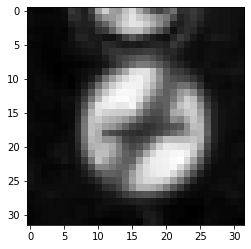

In [21]:
plt.imshow( color.rgb2gray( X_train[0]), cmap=plt.get_cmap('gray') )